In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [71]:
df = pd.read_csv('dataset.csv').sample(frac=1)

df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Class_att
50977,238.0,228.0,241.25,233.34,30016.0,4443.0,0.0,2.05440,5.5598,1.4635,1.8777,1.0739,3.4964,0.0,1.0
190707,245.0,240.0,248.00,248.00,923.0,0.0,0.0,1.79290,3.5697,0.0000,3.4155,1.7056,20.0000,1.2,0.0
135539,227.0,224.0,237.22,229.26,681.0,364.0,0.0,2.52590,9.5246,2.8050,5.0556,4.2254,1.6053,36.4,1.0
232078,240.0,218.0,239.90,219.34,6644.0,1951.0,54.0,0.65605,8.3599,4.5605,3.0742,1.7571,1.8490,0.0,1.0
192421,239.0,230.0,241.90,233.96,2479.0,367.0,0.0,3.23690,5.6980,1.1520,5.2961,3.1215,19.9510,0.0,0.0


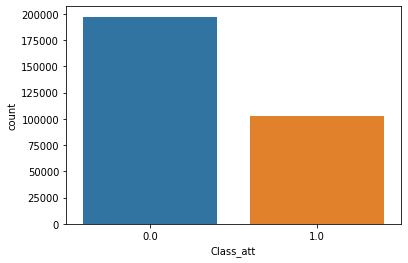

In [72]:
sns.countplot(x = 'Class_att', data=df)

In [73]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1].astype(int)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=69)

In [75]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [76]:
EPOCHS = 150
BATCH_SIZE = 256
LEARNING_RATE = 0.001

In [77]:
labels_unique, counts = np.unique(y_train, return_counts=True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in y_train]

In [78]:
sampler = WeightedRandomSampler(example_weights, len(y_train))

In [79]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [80]:
train_loader = DataLoader(dataset=train_data, sampler=sampler, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [81]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 14.
        self.layer_1 = nn.Linear(14, 64) 
        self.layer_2 = nn.Linear(64, 128)
        self.layer_3 = nn.Linear(128, 256)
        self.layer_4 = nn.Linear(256, 128)
        self.layer_5 = nn.Linear(128, 64)
        self.layer_6 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.batchnorm5 = nn.BatchNorm1d(64)
        self.batchnorm6 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)
        x = self.relu(self.layer_6(x))
        x = self.batchnorm6(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [83]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=14, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=128, bias=True)
  (layer_5): Linear(in_features=128, out_features=64, bias=True)
  (layer_6): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [84]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

Epoch 001: | Loss: 0.63769 | Acc: 63.196
Epoch 002: | Loss: 0.62456 | Acc: 64.605
Epoch 003: | Loss: 0.61764 | Acc: 65.167
Epoch 004: | Loss: 0.61033 | Acc: 65.972
Epoch 005: | Loss: 0.60464 | Acc: 66.389
Epoch 006: | Loss: 0.59765 | Acc: 67.104
Epoch 007: | Loss: 0.59087 | Acc: 67.692
Epoch 008: | Loss: 0.58497 | Acc: 68.190
Epoch 009: | Loss: 0.58203 | Acc: 68.458
Epoch 010: | Loss: 0.57552 | Acc: 68.994
Epoch 011: | Loss: 0.57058 | Acc: 69.388
Epoch 012: | Loss: 0.56612 | Acc: 69.582
Epoch 013: | Loss: 0.56146 | Acc: 70.020
Epoch 014: | Loss: 0.55763 | Acc: 70.456
Epoch 015: | Loss: 0.55445 | Acc: 70.629
Epoch 016: | Loss: 0.55065 | Acc: 70.939
Epoch 017: | Loss: 0.54657 | Acc: 71.236
Epoch 018: | Loss: 0.54378 | Acc: 71.443
Epoch 019: | Loss: 0.54003 | Acc: 71.648
Epoch 020: | Loss: 0.53607 | Acc: 71.985
Epoch 021: | Loss: 0.53342 | Acc: 72.284
Epoch 022: | Loss: 0.53216 | Acc: 72.233
Epoch 023: | Loss: 0.52820 | Acc: 72.583
Epoch 024: | Loss: 0.52736 | Acc: 72.656
Epoch 025: | Los

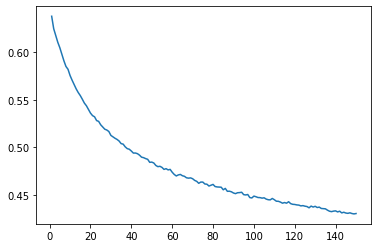

In [85]:
losses = []
accs = []

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    loss = epoch_loss/len(train_loader)
    acc = epoch_acc/len(train_loader)

    losses.append(loss)
    accs.append(acc)

    print(f'Epoch {e+0:03}: | Loss: {loss:.5f} | Acc: {acc:.3f}')

plt.plot(range(1, EPOCHS+1), losses)
plt.show()

In [86]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [87]:
confusion_matrix(y_test, y_pred_list)

array([[117,  60],
       [ 29,  94]])

In [88]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72       177
           1       0.61      0.76      0.68       123

    accuracy                           0.70       300
   macro avg       0.71      0.71      0.70       300
weighted avg       0.72      0.70      0.71       300



In [89]:
df = pd.read_csv('X_test.csv')

df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14
0,246.00,226.0,243.27,233.43,7121.0,648.0,0.0,1.1235,5.5226,1.9747,2.3390,1.1438,5.3022,0.0
1,239.00,226.0,240.77,233.31,2109.0,560.0,0.0,5.7154,6.3213,1.5999,4.3318,3.1834,3.0579,0.0
2,251.62,232.0,245.82,233.57,199.0,14.0,0.0,3.4131,5.7395,1.2936,5.6142,2.0601,20.0000,0.0
3,253.00,243.0,249.18,249.18,4095.0,0.0,0.0,10.3200,2.5050,0.0000,1.5908,1.2399,20.0000,0.0
4,247.00,240.0,248.12,248.12,321.0,0.0,0.0,10.8170,3.4157,0.0000,4.2366,1.2236,20.0000,0.0


In [90]:
scaler = StandardScaler()
x_test = scaler.fit_transform(df)
test_loader = DataLoader(dataset=x_test, batch_size=1)

In [91]:
model.eval()
output = []
for batch in test_loader:
    batch = batch.to(device).float()
    y = model(batch)
    y = torch.sigmoid(y)
    # y = torch.round(y)
    y = y.data
    y = y.cpu()
    y = y.numpy()
    output.append(y[0][0])

In [92]:
Yte = np.vstack((np.arange(df.shape[0]), np.array(output))).T
np.savetxt('Y_submit.txt', Yte, '%d, %.2f', header='ID,Prob1',
           comments='', delimiter=',')